In [24]:
import requests
from pathlib import Path
if Path("helper_functins.py").is_file():
  print("exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

In [25]:
#PyTorch Computer Vision

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [26]:
#Get Dataset (We using Fashion MNIST)
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

In [27]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

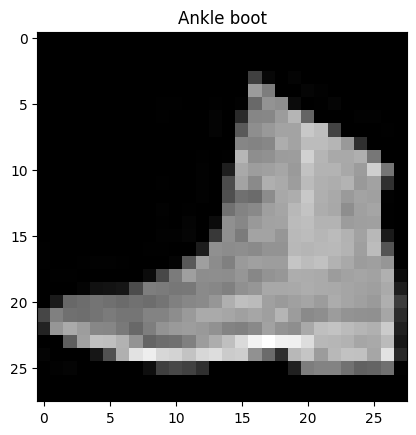

In [28]:
class_names = train_data.classes
#We divide the dataset because tehre are too many images so we make mini batches of generally size 32
#This also gives more chance for nn to update the gradients per epoch
#Hence we prepare DataLoaders
from torch.utils.data import DataLoader
#Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader = DataLoader(dataset = test_data,batch_size = BATCH_SIZE,shuffle = False)
train_features_batch,train_labels_batch = next(iter(train_dataloader))

torch.manual_seed(45)
random_idx = torch.randint(0,len(train_features_batch),size = [1]).item()
img,label = train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap = "gray")
plt.title(class_names[label]);



In [29]:
#Create a flatten layer
flatten_model = nn.Flatten()
x = train_features_batch[0]

output = flatten_model(x)
x.shape,output.shape
#This actully gives us a seperate dimension for each pixel

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [30]:
#Functioning train and test loops
def train_step(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device = device):
  train_loss,train_acc = 0, 0
  model.train()

  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device),y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y,y_pred = y_pred.argmax(dim = 1))

    #We use optimiser (SGD) for reassigning the weights and biases
    optimizer.zero_grad()
    #For loss we use the cross entropy loss
    loss.backward()
    #Here backpropogation takes palce and the weights get updated
    optimizer.step()

  train_loss /= len(train_dataloader)

  train_acc /= len(data_loader)

  print(f"\nTrain loss:{train_loss:.4f}| Train_acc:{train_acc: .2f}")



In [31]:
#This is a function for our testing loop
def test_step(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device = device):
  test_loss,test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device),y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred,y)
      test_acc += accuracy_fn(y_true = y,y_pred = test_pred.argmax(dim = 1))

    test_loss /= len(data_loader)

    test_acc /= len(data_loader)

    print(f"\nTest loss:{test_loss:.4f}| Test_acc:{test_acc: .2f}")

In [32]:
#Now we build a CNN (Convolutional Neural Network)
#Here we build convolution layers along with non-linear functions like ReLU  and also for the final classification we
#use the maxpool function which assigns
#weights based on the grids and takes the max of the given grid
class FashionMNISTModelV2(nn.Module):
  def __init__(self,input_layer:int,hidden_units:int,output_layer:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_layer,out_channels = hidden_units,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,out_channels = hidden_units,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    #Kernel size is a dimension which contains weights from a specified amount of pixels. It analyses these weights
    #and passes the relevant values through to subsequent layers
    #Smaller kernel size increases the accuracy of our model but also increases the time of computing

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,out_channels = hidden_units,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,out_channels = hidden_units,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,out_features = output_layer)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


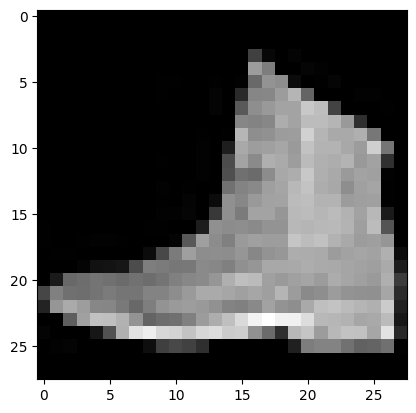

In [33]:
torch.manual_seed(45)
model_2 = FashionMNISTModelV2(input_layer = 1,hidden_units = 16,output_layer = len(class_names)).to(device)
plt.imshow(img.squeeze(),cmap = "gray")

In [34]:
#Loss function and optimizer along with the train and test loops
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),lr = 0.1)

torch.manual_seed(45)
torch.cuda.manual_seed(45)

epochs = 3

for epoch in range(epochs):
  print(f"Epoch:{epoch}\n.......")
  train_step(model = model_2,data_loader = train_dataloader,loss_fn = loss_fn,optimizer= optimizer,accuracy_fn = accuracy_fn,device = device)
  test_step(model = model_2,data_loader = test_dataloader,loss_fn = loss_fn,accuracy_fn = accuracy_fn,device = device)

Epoch:0
.......

Train loss:0.5816| Train_acc: 78.86

Test loss:0.3648| Test_acc: 86.89
Epoch:1
.......

Train loss:0.3328| Train_acc: 87.99

Test loss:0.3195| Test_acc: 88.40
Epoch:2
.......

Train loss:0.2957| Train_acc: 89.23

Test loss:0.3584| Test_acc: 86.28


In [35]:
def make_predictions(model:torch.nn.Module,data:list,device:torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim = 0).to(device)

      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze(),dim = 0)

      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

#Here we take in the predictions and store them in a list

Text(0.5, 1.0, 'T-shirt/top')

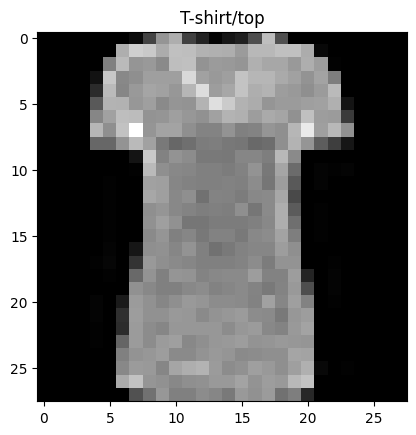

In [36]:
import random
random.seed(45)
test_samples = []
test_labels = []

for sample,label in random.sample(list(test_data),k = 9):
  test_samples.append(sample)
  test_labels.append(label)

plt.imshow(test_samples[0].squeeze(),cmap = "gray")
plt.title(class_names[test_labels[0]])

#This is how the data looks

In [37]:
#Make the prediction
pred_probs = make_predictions(model = model_2,data = test_samples)

pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([0, 5, 6, 2, 9, 8, 7, 3, 2])

In [38]:
test_labels

[0, 5, 0, 2, 9, 8, 7, 3, 4]

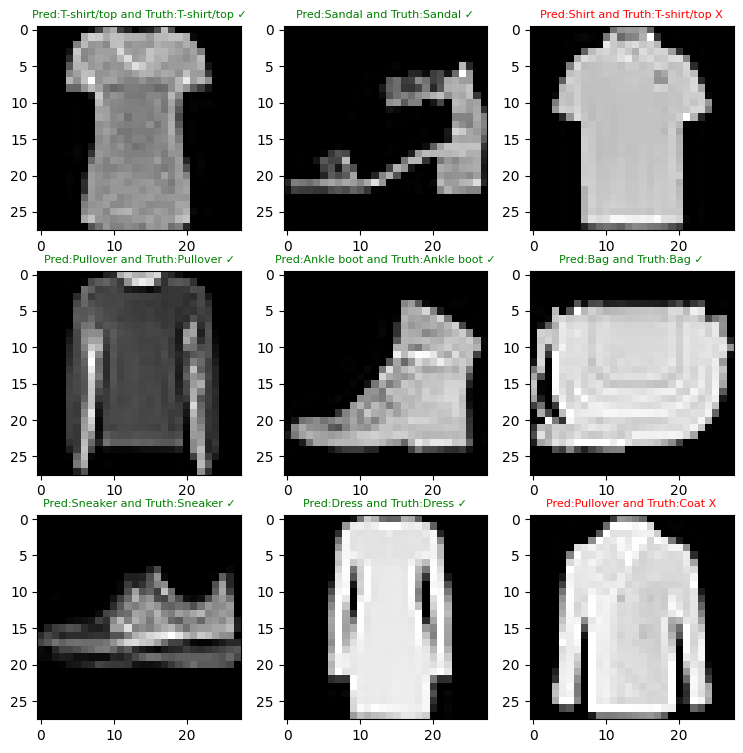

In [39]:
#Plot the Predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):

  plt.subplot(nrows,ncols,i+1)

  plt.imshow(sample.squeeze(),cmap = "gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred:{pred_label} and Truth:{truth_label}"

  if pred_label == truth_label:
    plt.title(title_text+" ✓",fontsize = 8,c = 'g')

  else:
    plt.title(title_text+ " X",fontsize = 8,c = 'r')

In [40]:
#Here we see that our model does exceptionally well in certain classes but it gets confused in items that look similar
#For example in reality there isnt much difference between a shirt and a T-Shirt/Top so its natural for the neural
#network to get confused in this case
#So lets find out how muh this occurs by creating a Confusion Matrix

In [41]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X,y in test_dataloader:
    X,y = X.to(device), y.to(device)

    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit.squeeze(),dim = 0).argmax(dim = 1)

    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor
#These are all the predictions for the entire model test data

tensor([9, 2, 1,  ..., 8, 1, 0])

In [42]:
len(y_pred_tensor)

10000

In [43]:
try:
  import torchmetrics,mlxtend
  assert int(mlxtend.__version__.split(".")[1])>=19

except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics,mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.2 MB/s eta 0:00:00


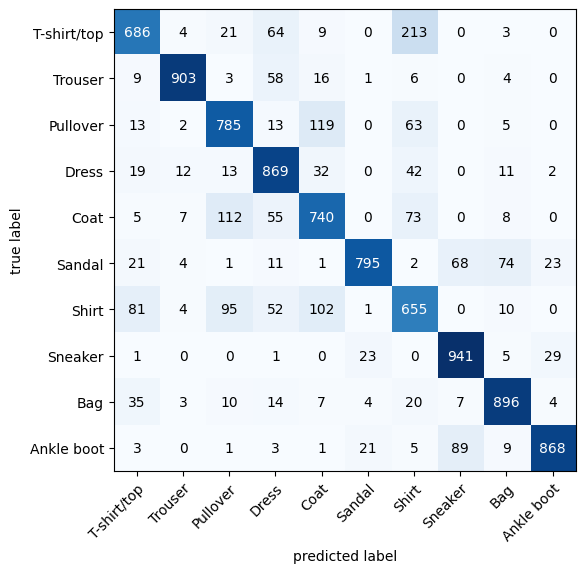

In [50]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task = 'multiclass', num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,target = test_data.targets)

fig,ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (10,6)
)


In [46]:
#Here as expected our model does perform pretty good excpet in 213 instances it predicts shirt to
#T-shirt and several instances of predicting coats to pullovers
#This slight inconsistency can be decreased by training the model for more epochs or creating
#more hidden layers in our neural network


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']